#                        Making the model to detect fake news

In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from pandas_ml import ConfusionMatrix
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import HashingVectorizer
import itertools
import numpy as np
import zipfile
from zipfile import ZipFile

### Investigating Fake News Detection with Scikit-Learn

Detecting so-called "fake news" is no easy task. First, there is defining what fake news is -- given it has now become a 
political statement. If you can find or agree upon a definition, then you must collect and properly label real and f
ake news (hopefully on similar topics to best show clear distinctions). Once collected, you must then find useful features 
to determine fake from real news.

For a more in-depth look at this problem space, I recommend taking a look at Miguel Martinez-Alvarez's post "How can Machine Learning and AI Help Solve the Fake News Problem".

Around the same time I read Miguel's insightful post, I came across an open data science post about building a successful fake news detector with Bayesian models.

In this notebook, I walk through some of my initial exploration  and see if I can build a successful fake news detector 


### Data Exploration


To begin, you should always take a quick look at the data and get a feel for its contents. To do so, use a Pandas DataFrame
and check the shape, head and apply any necessary transformations.

In [2]:
zf =zipfile.ZipFile('fdata.zip')
fn = pd.read_csv(zf.open('fake_or_real_news.csv'))

In [3]:
fn.shape

(6335, 4)

In [4]:
fn.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
fn = fn.set_index("Unnamed: 0")

In [7]:
fn.head()

,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


#### Extracting the training data


Now that the DataFrame looks closer to what I need, we  want to separate the labels and set up training and test datasets.

For this Fake _News _Detection_Model, I decided to focus on using the longer article text. Because I knew I would be using 
bag-of-words and 
Term Frequency–Inverse Document Frequency (TF-IDF) to extract features, this seemed like a good choice. Using longer text will
hopefully allow for distinct words and features for my real and fake news data

Sperating the labels 

In [8]:
y = fn.label

In [9]:
fn = fn.drop('label', axis=1)

In [10]:
fn.head()

,title,text
Unnamed: 0,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello..."
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...


### Make training and test sets 

In [11]:

X_train, X_test, y_train, y_test = train_test_split(fn['text'], y, test_size=0.33, random_state=53)


### Building Vectorizer Classifiers

Now  I  have my training and testing data, I can build your classifiers. To get a good idea if the words and tokens in 
the articles had a significant impact on whether the news was fake or real, I begin by using 
CountVectorizer and TfidfVectorizer.

I 'll see the example has a max threshhold set at .7 for the TF-IDF vectorizer tfidf_vectorizer using the max_df argument. 
This removes words which appear in more than 70% of the articles. Also, the built-in stop_words parameter will remove 
English stop words from the data before making vectors.

There are many more parameters avialable and you can read all about them in the scikit-learn documentation for TfidfVectorizer 
and CountVectorizer.

#### Initialize the count_vectorizer


In [12]:
count_vectorizer = CountVectorizer(stop_words='english')

#### Fit and transform the training data

In [13]:
count_train = count_vectorizer.fit_transform(X_train) # It will Learn the vocabulary dictionary and return term-document matrix.

#### Transform the test set

In [15]:

count_test = count_vectorizer.transform(X_test)

#### Initialize the tfidf_vectorizer

In [16]:
#This removes words which appear in more than 70% of the articles

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)


#### Fit and transform the training data

In [17]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

#### Transform the test set 


In [18]:
tfidf_test = tfidf_vectorizer.transform(X_test)

Now We have vectors, you can then take a look at the vector features, stored in count_vectorizer and tfidf_vectorizer.

Are there any noticable issues? (Yes!)

There are clearly comments, measurements or other nonsensical words as well as multilingual articles in the dataset that you 
have been using. Normally, you would want to spend more time preprocessing this and removing noise, but as this tutorial just 
showcases a small proof of concept, we will see if the model can overcome the noise and properly classify despite these issues.

#### Get the feature names of tfidf_vectorizer

In [19]:
print(tfidf_vectorizer.get_feature_names()[-10:])

['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']


#### Get the feature names of count_vectorizer

In [21]:

print(count_vectorizer.get_feature_names()[:10])

['00', '000', '0000', '00000031', '000035', '00006', '0001', '0001pt', '000ft', '000km']


#### Count versus TF-IDF Features

I was curious if my count and TF-IDF vectorizers had extracted different tokens. To take a look and compare features, 
we can extract the vector information back into a DataFrame to use easy Python comparisons.

As you can see by running the cells below, both vectorizers extracted the same tokens, but obviously have different weights. 
Likely, changing the max_df and min_df of the TF-IDF vectorizer could alter the result and lead to different features in each.

In [22]:
count_fn = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

tfidf_fn = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

difference = set(count_fn.columns) - set(tfidf_fn.columns)

#### Check whether the DataFrames are equal

In [23]:
print(count_fn.equals(tfidf_fn))

False


In [24]:
count_fn.head()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
tfidf_fn.head()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Comparing Model 

Now it's time to train and test your models.

Here, 'll begin with an NLP favorite, MultinomialNB. You can use this to compare TF-IDF versus bag-of-words.
My intuition was that bag-of-words (aka CountVectorizer) would perform better with this model. 
(For more reading on multinomial distribution and why it works best with integers, check out this fairly succinct explanation 
from a UPenn statistics course).

I personally find Confusion Matrices easier to compare and read, so I used the scikit-learn documentation to build 
some easily-readable confusion matrices (thanks open source!). A confusion matrix shows the proper labels on the main diagonal 
(top left to bottom right). The other cells show the incorrect labels, often referred to as false positives or false negatives. 
Depending on your problem, one of these might be more significant. For example, for the fake news problem, is it more important 
that we don't label real news articles as fake news? If so, we might want to eventually weight our accuracy score to better 
reflect this concern.

Other than Confusion Matrices, scikit-learn comes with many ways to visualize and compare your models. 

### Function to plot the confusion matrix 
.
    


 """
    For the confusion matrix i have taken help from here:
    
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Naive Bayes classifier for Multinomial model 

#### Making Model on Tfidf Vectorizer 

accuracy:   0.857
Confusion matrix, without normalization
[[ 739  269]
 [  31 1052]]


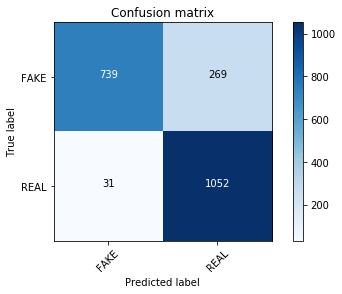

In [27]:
clf = MultinomialNB() 

clf.fit(tfidf_train, y_train)                       # Fit Naive Bayes classifier according to X, y

pred = clf.predict(tfidf_test)                      # Perform classification on an array of test vectors X.

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])
print(cm)

### Making Model in count vectorizer 

accuracy:   0.893
Confusion matrix, without normalization
[[ 865  143]
 [  80 1003]]


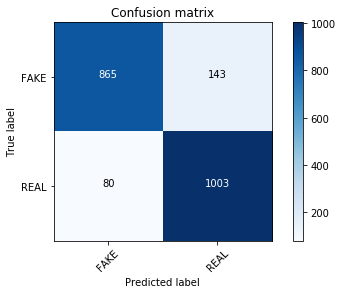

In [28]:

clf = MultinomialNB()

clf.fit(count_train, y_train)

pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])
print(cm)

And indeed, with absolutely no parameter tuning, your count vectorized training set count_train is visibly outperforming your 
TF-IDF vectors

### Testing Linear Models


There are a lot of great write-ups about how linear models work well with TF-IDF vectorizer 
            (take a look at word2vec for classification, SVM reference in scikit-learn text analysis, and many more).

we should use a SVM, right?

Well, I watched Victor Lavrenko's lecture on text classification and he compares Passive Aggressive classifiers to
linear SVM  for text classification.
I'll test this approach (which has some significant speed benefits and permanent learning disadvantages) with the fake news 
dataset.

### Applying Passive Aggressive Classifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.934
Confusion matrix, without normalization
[[ 948   60]
 [  79 1004]]


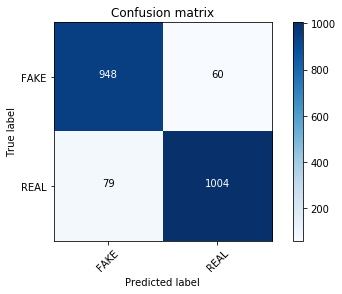

In [29]:

linear_clf = PassiveAggressiveClassifier(n_iter=50)

linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])
print(cm)

Here I found something amazing :

I'm impressed. The confusion matrix looks different and the model classifies our fake news a bit better. 
Here I am  testing if tuning the alpha value for a MultinomialNB creates comparable results. You can also use parameter tuning with 
grid search for a more exhaustive search

###   Additive (Laplace/Lidstone) smoothing parameter

In [30]:
clf = MultinomialNB(alpha=0.1)               

last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00 Score: 0.88140
Alpha: 0.10 Score: 0.89766
Alpha: 0.20 Score: 0.89383
Alpha: 0.30 Score: 0.89000
Alpha: 0.40 Score: 0.88570
Alpha: 0.50 Score: 0.88427
Alpha: 0.60 Score: 0.87470
Alpha: 0.70 Score: 0.87040
Alpha: 0.80 Score: 0.86609
Alpha: 0.90 Score: 0.85892


After getting the result I am thinking :

At this point, it might be interesting to perform parameter tuning across all of the classifiers, or take a look at some other
scikit-learn Bayesian classifiers. 
You could also test with a Support Vector Machine (SVM) to see if that outperforms the Passive Aggressive classifier.

But I am a bit more curious about what the Passive Aggressive model actually has learned. So let's move onto introspection

### Doing some Stuff with the model 

 Not quite, i am very execite to see the result on feature extraction : 

There is a great write-up on StackOverflow with this incredibly useful function for finding vectors that most affect labels. 
It only works for binary classificaiton (classifiers with 2 classes), but that's good news for you, since you only have FAKE 
or REAL labels.

Using your best performing classifier with your TF-IDF vector dataset (tfidf_vectorizer) and Passive Aggressive classifier 
(linear_clf), inspect the top 30 vectors for fake and real news:

 """
    Here I am using   a code written on stackoverflow that for binary classifiaction
    
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

In [31]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100): # inspect the top 30 vectors for 
                                                                                              #fake and real news
   
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()  # Array mapping from feature integer indices to feature name
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)
feature_names = tfidf_vectorizer.get_feature_names()

### Most real
sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20]

### Most fake
sorted(zip(clf.coef_[0], feature_names))[:20] 
# clearly there are certain words which might show political intent and source in the top fake features  
                                                      #(such as the words corporate and establishment).

tokens_with_weights = sorted(list(zip(feature_names, clf.coef_[0])))

FAKE -4.9394072065630175 2016
FAKE -4.446568516854838 october
FAKE -4.125160343116697 hillary
FAKE -3.0531200128392326 share
FAKE -2.982828699181522 article
FAKE -2.861428486601598 november
FAKE -2.6915445999324095 print
FAKE -2.5525510997292242 email
FAKE -2.3473716620872485 advertisement
FAKE -2.3237925715719703 source
FAKE -2.3219284825893736 oct
FAKE -2.2034036580833147 war
FAKE -2.1861977156741106 podesta
FAKE -2.0921672340074613 mosul
FAKE -2.0816042325159403 establishment
FAKE -2.060786321165648 brexit
FAKE -2.0465660215590877 election
FAKE -1.974987216756279 corporate
FAKE -1.9575929753435584 nov
FAKE -1.906153836817859 wikileaks
FAKE -1.8782202381469781 com
FAKE -1.8604921328890305 snip
FAKE -1.7265880032113947 dakota
FAKE -1.7254044996987168 dr
FAKE -1.7048933775258512 ayotte
FAKE -1.6771300482327156 soros
FAKE -1.6739275494936645 pipeline
FAKE -1.6572062598617345 photo
FAKE -1.6185595601234652 donald
FAKE -1.5817646570684085 jewish

REAL 4.913039393434032 said
REAL 2.6167728

### Hashing Vector

In [ ]:
Another vectorizer used sometimes for text classification is a HashingVectorizer. HashingVectorizers require less memory 
and are faster (because they are sparse and use hashes rather than tokens) but are more difficult to introspect. 
You can read a bit more about the pros and cons of using HashingVectorizer in the scikit-learn documentation if you
are interested.

we can give it a try and compare its results versus the other vectorizers. It performs fairly well, with better results 
than the TF-IDF vectorizer using MultinomialNB (this is somewhat expected due to the same reasons CountVectorizers perform 
better), but not as well as the TF-IDF vectorizer with Passive Aggressive linear algorithm

In [32]:

# HashingVectorizer : require less memory and are faster (because they are sparse and use hashes rather than tokens)


hash_vectorizer = HashingVectorizer(stop_words='english', non_negative=True)
hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


### Applying hashing vector on  Naive Bayes classifier for Multinomial model

accuracy:   0.902
Confusion matrix, without normalization
[[ 883  125]
 [  80 1003]]


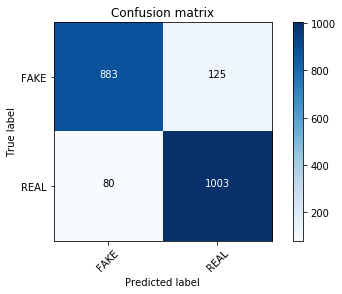

In [33]:


clf = MultinomialNB(alpha=.01)

clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])
print(cm)


### Applying Hasing vector on Passive Aggressive Classifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.919
Confusion matrix, without normalization
[[937  71]
 [ 98 985]]


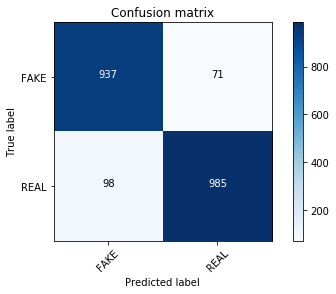

In [34]:



clf = PassiveAggressiveClassifier(n_iter=50)    

clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])
print(cm)


### Conclusion 

As expected, the bag-of-words and TF-IDF vectors didn't do much to determine meaningful features to classify fake or real news.

That said, I did learn a few things. Namely, that linear models handle noise in this case better than the Naive Bayes 
multinomial classifier did. Also, finding a good dataset that has been scraped from the web and tagged for this problem 
would likely be a great help, and worth more of my time than parameter tuning on a clearly noisy and error prone dataset.

I hope you had some fun exploring a new NLP dataset with me!